In [1]:
import instruments as inst
import copy
import numpy as np

# Step 1.a): Reading in csv - extracting single diffs and sums and configurations

In [2]:
file_path = "20230914_processed_table.csv"
wavelength_string = 610
obs_mode = "MBI"

interleaved_values, interleaved_stds, configuration_list = inst.read_csv(file_path, 
    obs_mode = obs_mode, obs_filter = wavelength_string)
print("Interleaved Values")
print("Length: ", len(interleaved_values))
print(interleaved_values[0 : 10])
print("Interleaved Stds")
print("Length: ", len(interleaved_stds))
print(interleaved_stds[0 : 10])
print("Configuration List")
print("Length: ", len(configuration_list))
print(configuration_list[0 : 10])
print(interleaved_stds[0])

Interleaved Values
Length:  320
[ 19866.   23740.5 -22265.5  22477.5  13337.5  22094.5 -15543.5  21181.5
  -1825.5  18824. ]
Interleaved Stds
Length:  320
[688.95936526 798.7614491  791.45797182 797.27596033 531.8586925
 800.67495167 727.56322485 816.37585171 198.75093928 698.70510581]
Configuration List
Length:  160
[{'hwp': {'theta': 0.0}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 0.0}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 0.0}, 'image_rotator': {'theta': 57.5}}, {'hwp': {'theta': 0.0}, 'image_rotator': {'theta': 57.5}}, {'hwp': {'theta': 0.0}, 'image_rotator': {'theta': 70.0}}, {'hwp': {'theta': 0.0}, 'image_rotator': {'theta': 70.0}}, {'hwp': {'theta': 0.0}, 'image_rotator': {'theta': 82.5}}, {'hwp': {'theta': 0.0}, 'image_rotator': {'theta': 82.5}}, {'hwp': {'theta': 0.0}, 'image_rotator': {'theta': 95.0}}, {'hwp': {'theta': 0.0}, 'image_rotator': {'theta': 95.0}}]
688.95936526


# Step 1.b) - Make plot of existing values as double diffs and sums

# Step 2: Creating a system Mueller matrix object

In [3]:
# Loading in previous fit from vampires_calibration
past_fit = np.load("scipy_minimize_20230914_675nm_restrictive_HWP_and_IMR.npy")
print("Past Fit: ", past_fit)

theta_pol = past_fit[0]
delta_HWP = past_fit[1]
offset_HWP = past_fit[2]
delta_derot = past_fit[3]
offset_derot = past_fit[4]
delta_opts = past_fit[5]
epsilon_opts = past_fit[6]
rot_opts = past_fit[7]
delta_FLC = past_fit[8]
rot_FLC = past_fit[9]
em_gain = past_fit[10]

# NOTE: Components must be listed downstream to upstream
# Define the instrument configuration as a system dictionary
system_dict = {
    "components": {
        "wollaston": {
            "type": "wollaston_prism_function",
            "properties": {"beam": "o", "transmission_ratio": em_gain},
        },
        "dichroic": {
            "type": "general_retarder_function",
            "properties": {"phi": 0, "theta": 0},
        },
        "flc": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_FLC, "theta": 0, "delta_theta": rot_FLC},
        },
        "optics": {
            "type": "diattenuator_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_opts, "epsilon": epsilon_opts, "theta": rot_opts},
        },
        "image_rotator": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_derot, "theta": 0, "delta_theta": offset_derot},
        },
        "hwp": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_HWP, "theta": 0, "delta_theta": offset_HWP},
        },
        "lp": {
            "type": "general_linear_polarizer_function_with_theta",
            "properties": {"theta": theta_pol},
        },
        # Testing whether generate_system_mueller_matrix can flag this as a non-existent component
        "test_false_type": {
            "type": "test",
            "properties": {"theta": 0, "epsilon": 0}
        },
        # Testing whether generate_system_mueller_matrix can flag epsilon as a
        # non-existent property of rotator
        "test_false_property": {
            "type": "general_retarder_function",
            "properties": {"epsilon": 0}
        }
    }
}

Past Fit:  [ 1.53307627  0.46163077 -2.3687464   0.32815156 -4.99600063 -0.20433489
  0.02210595 18.49730849  0.52007057  4.99645591  1.19152714]


In [4]:
# Converting system dictionary into system Mueller Matrix object

system_mm = inst.generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())

Error: 'test' is not a valid function in pyMuellerMat.common_mm_functions and will be skipped.
[[0.51859792 0.51785552 0.02773924 0.        ]
 [0.51859792 0.51785552 0.02773924 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


# TEST: Checking parse_configuration & update_system_mm

In [5]:
test_configuration = {
    'lp': {'theta': 0.0},
    'hwp': {'theta': 0.0},
    'image_rotator': {'theta': 0.0},
    'flc': {'theta': 0.0},
    'wollaston': {'beam': 'o'}
    }

values, keywords = inst.parse_configuration(test_configuration)
print("Values: " + str(values))
print("Keywords: " + str(keywords))

updated_system_mm = inst.update_system_mm(values, keywords, system_mm)
# print(updated_system_mm.evaluate())


Values: [0.0, 0.0, 0.0, 0.0, 'o']
Keywords: [['lp', 'theta'], ['hwp', 'theta'], ['image_rotator', 'theta'], ['flc', 'theta'], ['wollaston', 'beam']]


# Step 4: Creating a dictionary of p0 starting guesses

In [6]:
# Fittin for just the dichroic for now

p0 = {
    "dichroic": {"phi": 0, "theta": 0}
}

p0_values, p0_keywords = inst.parse_configuration(p0)

# Step 5: Running minimize_system_Mueller_matrix

In [7]:
# Unpolarized light for s_in as there is LP in the system already
s_in = np.array([1, 0, 0, 0])

result = inst.minimize_system_mueller_matrix(p0, system_mm, interleaved_values, 
    interleaved_stds, configuration_list, s_in = s_in,
    process_dataset = inst.process_dataset, process_errors = inst.process_errors, 
    process_model = inst.process_model)
print(result.x)

p0_values:  [0, 0]
p0_keywords:  [['dichroic', 'phi'], ['dichroic', 'theta']]
Entered logl
Entered process_model
Differences shape:  (160,)
Sums shape:  (160,)
Double Differences shape:  (80,)
Double Sums shape:  (80,)
Output Intensities:  (160,)
Pre process_dataset dataset shape:  (320,)
Entered process_dataset
Pre np.array Input dataset:  (320,)
Post np.array Input dataset:  (320,)
Differences shape:  (160,)
Sums shape:  (160,)
Post process_dataset dataset shape:  (160,)
Pre process_errors errors shape:  (320,)
Entered process_errors
Pre-processing Errors shape:  (320,)
Pre-processing Dataset shape:  (320,)
Differences Errors shape:  (160,)
Sums Errors shape:  (160,)
Double Differences Errors shape:  (80,)
Double Sums Errors shape:  (80,)
Final interleaved Errors shape:  (160,)
Post process_errors errors shape:  (160,)
Entered logl
Entered process_model
Differences shape:  (160,)
Sums shape:  (160,)
Double Differences shape:  (80,)
Double Sums shape:  (80,)
Output Intensities:  (160,


Differences shape:  (160,)
Sums shape:  (160,)
Double Differences shape:  (80,)
Double Sums shape:  (80,)
Output Intensities:  (160,)
Pre process_dataset dataset shape:  (320,)
Entered process_dataset
Pre np.array Input dataset:  (320,)
Post np.array Input dataset:  (320,)
Differences shape:  (160,)
Sums shape:  (160,)
Post process_dataset dataset shape:  (160,)
Pre process_errors errors shape:  (320,)
Entered process_errors
Pre-processing Errors shape:  (320,)
Pre-processing Dataset shape:  (320,)
Differences Errors shape:  (160,)
Sums Errors shape:  (160,)
Double Differences Errors shape:  (80,)
Double Sums Errors shape:  (80,)
Final interleaved Errors shape:  (160,)
Post process_errors errors shape:  (160,)
Entered logl
Entered process_model
Differences shape:  (160,)
Sums shape:  (160,)
Double Differences shape:  (80,)
Double Sums shape:  (80,)
Output Intensities:  (160,)
Pre process_dataset dataset shape:  (320,)
Entered process_dataset
Pre np.array Input dataset:  (320,)
Post np

# Step 6: Plot model with best fit

[0. 0.]
[['dichroic', 'phi'], ['dichroic', 'theta']]
Entered process_model
Differences shape:  (160,)
Sums shape:  (160,)
Double Differences shape:  (80,)
Double Sums shape:  (80,)
Model Length:  160
Configurations List Length:  160
Entered process_errors
Pre-processing Errors shape:  (320,)
Pre-processing Dataset shape:  (320,)
Differences Errors shape:  (160,)
Sums Errors shape:  (160,)
Double Differences Errors shape:  (80,)
Double Sums Errors shape:  (80,)
Final interleaved Errors shape:  (160,)
Entered process_dataset
Pre np.array Input dataset:  (320,)
Post np.array Input dataset:  (320,)
Differences shape:  (160,)
Sums shape:  (160,)


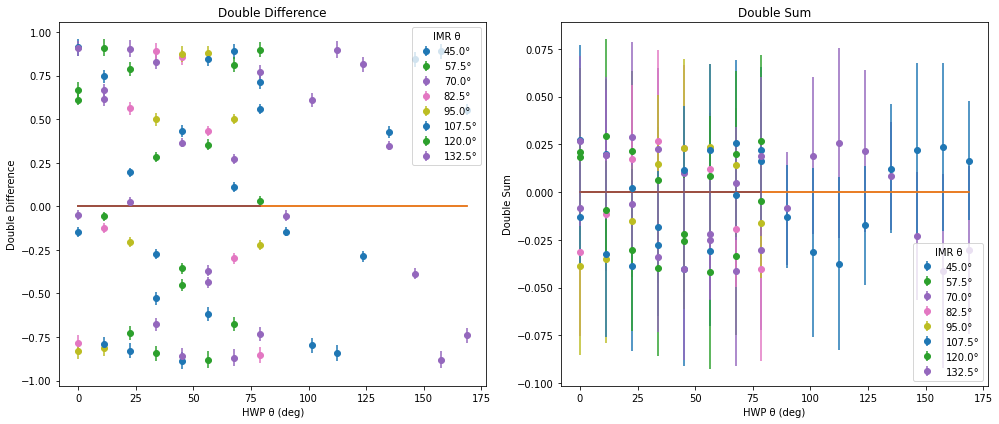

In [8]:
# Generate model with p0 keywords but scipy minimized results
print(result.x)
print(p0_keywords)

updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
model = inst.model(result.x, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)
print("Model Length: ", len(model))
print("Configurations List Length: ", len(configuration_list))

inst.plot_data(interleaved_values, interleaved_stds, model, configuration_list)